In [ ]:
!pip install tensorflow
!pip install torch

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
Pillow Version: 7.0.0
JPEG
RGB
(600, 800)
uint8
(800, 600, 3)


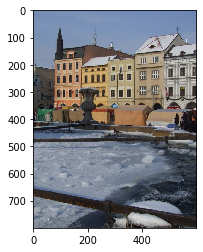

uint8
(800, 600, 3)


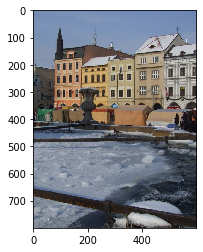

In [6]:
#Image manipulation using Pillow

!pip install Pillow

# check Pillow version number
import PIL

# load and show an image with Pillow
from PIL import Image
print('Pillow Version:', PIL.__version__)

# load the image
image = Image.open('train/0/0/0/0000059611c7d079.jpg')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# show the image
image.show()


# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread('train/0/0/0/0000059611c7d079.jpg')
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
data = image.imread('train/0/0/0/0000059611c7d079.jpg')
# summarize shape of the pixel array
print(data.dtype)
print(data.shape)
# display the array of pixels as an image
pyplot.imshow(data)
pyplot.show()

In [ ]:
import cv2#reading and resizing                 
import numpy as np#arrays         
import os#dealing with directories                  
from random import shuffle #to shuffle data
from tqdm import tqdm#loop progress bar  
from sklearn.metrics import roc_auc_score    
import matplotlib.pyplot as plt # for visualizations
import tensorflow as tf # For tensor operations
import pandas as pd # for manipulating data
import zipfile
import os, sys
import csv


#####
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

#Operating System
import os

#Tensorflow
import tensorflow as tf

In [ ]:
#HYPERPARAMETERS
# our photos are in the size of (80,80,3)
IMG_SIZE = 80

epochs = 30
step_size = 8
IMG_SIZE_ALEXNET = 227
validating_size = 40
nodes_fc1 = 4096
nodes_fc2 = 4096
output_classes = 4

In [ ]:
train_dir = os.path.join('/home/ec2-user/SageMaker/GoogleLandmarkRetrieval2020', 'train')
index_dir = os.path.join('/home/ec2-user/SageMaker/GoogleLandmarkRetrieval2020', 'index')
test_dir = os.path.join('/home/ec2-user/SageMaker/GoogleLandmarkRetrieval2020', 'test')
#print(os.getcwd())
print(train_dir)


In [ ]:
#Reading .csv files
train = pd.read_csv('train.csv')

test_dict = {'id':[], 'landmark_id':[]}
files = os.walk('test')
for file in files:
    images = file[-1]
    for image in images:
        if (str(image)[-4:] == ".jpg"):
            test_dict['id'].append(str(image)[:-4])
            test_dict['landmark_id'].append('')

test = pd.DataFrame(data = test_dict)
train = train.sort_values("id")

test.to_csv(r'test.csv', index = False)


In [ ]:
train_img = []

count = 0
for img_name in list(train['id']):
    if (count % 1000 == 0):
        print(count)
    count+=1
    if (count % 100000 == 0):
        break
    # defining the image path
    image_path = "train/" + str(img_name)[0] + "/" + str(img_name)[1] + "/" + str(img_name)[2] + "/" + str(img_name) + ".jpg"
    # reading the image
    img = imread(image_path, as_gray=True)
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float16')
    
    #img = tf.image.resize(img, [28,28,1])
    #print(tf.image.get_shape(img).ndims)
    # appending the image into the list
    train_img.append(img)
    
    #file_path = 'img_ids/' + 'img_id' + str(img_name) + '.csv'
    #np.savetxt(file_path, img, delimiter=",")
    
print(train_img[0])

In [ ]:
#Convert the csv to numpy arrays

train_dat = pd.read_csv('train.csv', header=0)
train_dat1 = pd.DataFrame(train_dat)

train_data = np.array(train_dat1.values)
#print(train_data)


test_dat = pd.read_csv('test.csv', header=0)
test_dat1 = pd.DataFrame(test_dat)

test_data = np.array(test_dat1.values)
#print(test_data)

In [ ]:
#In order to implement ALEXNET, we are resizing them to (227,227,3)
for i in range(len(train_data)):
    train_data[i][0] = cv2.resize(train_data[i][0],(IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET))

for i in range(len(test_data)):
    test_data[i][0] = cv2.resize(test_data[i][0],(IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET))

train = train_data[:4800]
cv = train_data[4800:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET,3)
Y = np.array([i[1] for i in train])

cv_x = np.array([i[0] for i in cv]).reshape(-1,IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET,3)
cv_y = np.array([i[1] for i in cv])
test_x = np.array([i[0] for i in test_data]).reshape(-1,IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET,3)
test_y = np.array([i[1] for i in test_data])

print(X.shape)

print(Y.shape)

print(cv_x.shape)

print(test_x.shape)

steps = len(train)
print(steps)
remaining = steps % step_size

In [ ]:
#Resetting graph
tf.reset_default_graph()

#Defining Placeholders
x = tf.placeholder(tf.float32,shape=[None,IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET,3])
y_true = tf.placeholder(tf.float32,shape=[None,output_classes])

##CONVOLUTION LAYER 1
#Weights for layer 1
w_1 = tf.Variable(tf.truncated_normal([11,11,3,96], stddev=0.01))
#Bias for layer 1
b_1 = tf.Variable(tf.constant(0.0, shape=[[11,11,3,96][3]]))
#Applying convolution
c_1 = tf.nn.conv2d(x, w_1,strides=[1, 4, 4, 1], padding='VALID')
#Adding bias
c_1 = c_1 + b_1
#Applying RELU
c_1 = tf.nn.relu(c_1)
								
print(c_1)
##POOLING LAYER1
p_1 = tf.nn.max_pool(c_1, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')
print(p_1)

##CONVOLUTION LAYER 2
#Weights for layer 2
w_2 = tf.Variable(tf.truncated_normal([5,5,96,256], stddev=0.01))
#Bias for layer 2
b_2 = tf.Variable(tf.constant(1.0, shape=[[5,5,96,256][3]]))
#Applying convolution
c_2 = tf.nn.conv2d(p_1, w_2,strides=[1, 1, 1, 1], padding='SAME')
#Adding bias
c_2 = c_2 + b_2
#Applying RELU
c_2 = tf.nn.relu(c_2)

print(c_2)

##POOLING LAYER2
p_2 = tf.nn.max_pool(c_2, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')
print(p_2)

##CONVOLUTION LAYER 3
#Weights for layer 3
w_3 = tf.Variable(tf.truncated_normal([3, 3, 256, 384], stddev=0.01))
#Bias for layer 3
b_3 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 256, 384][3]]))
#Applying convolution
c_3 = tf.nn.conv2d(p_2, w_3,strides=[1, 1, 1, 1], padding='SAME')
#Adding bias
c_3 = c_3 + b_3
#Applying RELU
c_3 = tf.nn.relu(c_3)

print(c_3)

##CONVOLUTION LAYER 4
#Weights for layer 4
w_4 = tf.Variable(tf.truncated_normal([3, 3, 384, 384], stddev=0.01))
#Bias for layer 4
b_4 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 384, 384][3]]))
#Applying convolution
c_4 = tf.nn.conv2d(c_3, w_4,strides=[1, 1, 1, 1], padding='SAME')
#Adding bias
c_4 = c_4 + b_4
#Applying RELU
c_4 = tf.nn.relu(c_4)

print(c_4)

##CONVOLUTION LAYER 5
#Weights for layer 5
w_5 = tf.Variable(tf.truncated_normal([3, 3, 384, 256], stddev=0.01))
#Bias for layer 5
b_5 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 384, 256][3]]))
#Applying convolution
c_5 = tf.nn.conv2d(c_4, w_5,strides=[1, 1, 1, 1], padding='SAME')
#Adding bias
c_5 = c_5 + b_5
#Applying RELU
c_5 = tf.nn.relu(c_5)

print(c_5)

##POOLING LAYER3
p_3 = tf.nn.max_pool(c_5, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')
print(p_3)

#Flattening
flattened = tf.reshape(p_3,[-1,6*6*256])
print(flattened)

##Fully Connected Layer 1
#Getting input nodes in FC layer 1
input_size = int( flattened.get_shape()[1] )
#Weights for FC Layer 1
w1_fc = tf.Variable(tf.truncated_normal([input_size, nodes_fc1], stddev=0.01))
#Bias for FC Layer 1
b1_fc = tf.Variable( tf.constant(1.0, shape=[nodes_fc1] ) )
#Summing Matrix calculations and bias
s_fc1 = tf.matmul(flattened, w1_fc) + b1_fc
#Applying RELU
s_fc1 = tf.nn.relu(s_fc1)

#Dropout Layer 1
hold_prob1 = tf.placeholder(tf.float32)
s_fc1 = tf.nn.dropout(s_fc1,keep_prob=hold_prob1)

print(s_fc1)

##Fully Connected Layer 2
#Weights for FC Layer 2
w2_fc = tf.Variable(tf.truncated_normal([nodes_fc1, nodes_fc2], stddev=0.01))
#Bias for FC Layer 2
b2_fc = tf.Variable( tf.constant(1.0, shape=[nodes_fc2] ) )
#Summing Matrix calculations and bias
s_fc2 = tf.matmul(s_fc1, w2_fc) + b2_fc
#Applying RELU
s_fc2 = tf.nn.relu(s_fc2)
print(s_fc2)

#Dropout Layer 2
hold_prob2 = tf.placeholder(tf.float32)
s_fc2 = tf.nn.dropout(s_fc2,keep_prob=hold_prob1)

##Fully Connected Layer 3
#Weights for FC Layer 3
w3_fc = tf.Variable(tf.truncated_normal([nodes_fc2,output_classes], stddev=0.01))
#Bias for FC Layer 3b3_fc = tf.Variable( tf.constant(1.0, shape=[output_classes] ) )
b3_fc = tf.Variable( tf.constant(1.0, shape=[output_classes] ) )
#Summing Matrix calculations and bias
y_pred = tf.matmul(s_fc2, w3_fc) + b3_fc
#Applying RELU
print(y_pred)

In [ ]:
#Defining loss function

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred))

#Defining objective
train = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(cross_entropy)

#Defining Accuracy
matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
acc = tf.reduce_mean(tf.cast(matches,tf.float32))

#Initializing weights
init = tf.global_variables_initializer()

In [ ]:
#Starting Empty lists to keep results
acc_list = []
auc_list = []
loss_list = []
saver = tf.train.Saver()


In [ ]:
#GPU settings
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
with tf.Session(config=config) as sess:
    sess.run(init)
    for i in range(epochs):
        for j in range(0,steps-remaining,step_size):
            #Feeding step_size-amount data with 0.5 keeping probabilities on DROPOUT LAYERS
            _,c = sess.run([train,cross_entropy],
			feed_dict={x:X[j:j+step_size] , y_true:Y[j:j+step_size],hold_prob1:0.5,hold_prob2:0.5})
        
        
		#Writing for loop to calculate test statistics. GTX 1050 isn't able to calculate all test data.
        cv_auc_list = []
        cv_acc_list = []
        cv_loss_list = []
        for v in range(0,len(cv_x)-int(len(cv_x) % validating_size),validating_size):
            acc_on_cv,loss_on_cv,preds = sess.run([acc,cross_entropy,tf.nn.softmax(y_pred)],
			feed_dict={x:cv_x[v:v+validating_size] ,y_true:cv_y[v:v+validating_size] ,hold_prob1:1.0,hold_prob2:1.0})
			
            auc_on_cv = roc_auc_score(cv_y[v:v+validating_size],preds)
            cv_acc_list.append(acc_on_cv)
            cv_auc_list.append(auc_on_cv)
            cv_loss_list.append(loss_on_cv)
        acc_cv_ = round(np.mean(cv_acc_list),5)
        auc_cv_ = round(np.mean(cv_auc_list),5)
        loss_cv_ = round(np.mean(cv_loss_list),5)
        acc_list.append(acc_cv_)
        auc_list.append(auc_cv_)
        loss_list.append(loss_cv_)
        print("Epoch:",i,"Accuracy:",acc_cv_,"Loss:",loss_cv_ ,"AUC:",auc_cv_)
    
    test_auc_list = []
    test_acc_list = []
    test_loss_list = []
    for v in range(0,len(test_x)-int(len(test_x) % validating_size),validating_size):
        acc_on_test,loss_on_test,preds = sess.run([acc,cross_entropy,tf.nn.softmax(y_pred)],
		feed_dict={x:test_x[v:v+validating_size] ,y_true:test_y[v:v+validating_size] ,hold_prob1:1.0,hold_prob2:1.0})
        
        auc_on_test = roc_auc_score(test_y[v:v+validating_size],preds)
        test_acc_list.append(acc_on_test)
        test_auc_list.append(auc_on_test)
        test_loss_list.append(loss_on_test)
    saver.save(sess, os.path.join(os.getcwd(),"CNN_MC.ckpt"))
    test_acc_ = round(np.mean(test_acc_list),5)
    test_auc_ = round(np.mean(test_auc_list),5)
    test_loss_ = round(np.mean(test_loss_list),5)
    print("Test Results are below:")
    print("Accuracy:",test_acc_,"Loss:",test_loss_,"AUC:",test_auc_)


f,ax=plt.subplots(1,3,figsize=(12,3))
pd.Series(acc_list).plot(kind='line',title='Accuracy on CV data',ax=ax[0])
pd.Series(loss_list).plot(kind='line',figsize=(12,7),title='Loss on CV data',ax=ax[1])
pd.Series(auc_list).plot(kind='line',figsize=(12,7),title='AUC on CV data',ax=ax[2])
plt.subplots_adjust(wspace=0.8)
ax[0].set_title('Accuracy on CV data')
ax[1].set_title('Loss on CV data')
ax[2].set_title('AUC on CV data')
plt.show()

In [ ]:
#Restoring a pretrained
with tf.Session() as session:
    saver.restore(session, "CNN_MC.ckpt")
    print("Model restored.") 
    print('Initialized')
    k = session.run([tf.nn.softmax(y_pred)], feed_dict={x:test_x[0:64] , hold_prob1:1,hold_prob2:1})

print(np.array(k).shape)


In [ ]:
#Reshaping k
k = np.array(k).reshape(64,output_classes)

print(k[0])

pred_labels = []

for i in range(64):
    r = np.round(k[i],3).argmax()
    if r ==0 : pred_labels.append("chair")
    elif r ==1: pred_labels.append("kitchen")
    elif r ==2: pred_labels.append("knife")
    elif r ==3: pred_labels.append("saucepan")

In [ ]:
#Multiple images parameters
w=80
h=80
columns = 8
rows = 8

#First 64 images
images = test_x[:64]

print(images.shape)

fig = plt.figure(figsize=(20, 20))
for m in range(1, columns*rows +1):
    img = images[m-1].reshape([IMG_SIZE_ALEXNET, IMG_SIZE_ALEXNET, 3])
    fig.add_subplot(rows, columns, m)
    plt.imshow(img)
    plt.title("Pred: " + pred_labels[m-1])
    plt.axis('off')
plt.show()